In [ ]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score 

In [ ]:
df_final = pd.read_csv("df_final.csv")

In [ ]:
cat_cols = ['os', 'browser','slot_id', "ssp_uid",'carrier_name', 'region','creative_type','sponsor_id','campaign_id','creative_id',"is_rt", 'request_hour',
       'request_month', 'request_day', 'request_dayofweek', 'rt_times']
for c in cat_cols:
    vv, obj = pd.factorize(df_final[c])
    df_final[c] = vv

In [ ]:
df_final = df_final.fillna(0)

In [ ]:
df_final = df_final.drop(["Unnamed: 0"], axis = 1)
df_final = df_final.drop(["request_time"], axis = 1)
df_final = df_final.drop(["click_time"], axis = 1)
df_final = df_final.drop(["cv_time"], axis = 1)
df_final = df_final.drop(["cv_flg"], axis = 1)
df_final = df_final.drop(["ssp_uid"], axis = 1)
df_final = df_final.drop(["req_id"], axis = 1)
df_final = df_final.drop(["os"], axis = 1)
df_final = df_final.drop(["carrier_name"], axis = 1)
df_final = df_final.drop(["request_month"], axis = 1)
df_final = df_final.drop(["request_dayofweek"], axis = 1)
df_final = df_final.drop(["rt_times"], axis = 1)
df_final = df_final.drop(["cv_flg_0"], axis = 1)
df_final = df_final.drop(["click_flg_1"], axis = 1)
df_final = df_final.drop(["cv_flg_1"], axis = 1)
df_final = df_final.drop(["click_flg_2"], axis = 1)
df_final = df_final.drop(["cv_flg_2"], axis = 1)

In [ ]:
# クリックデータのカテゴリ変数を整数としてエンコードする
from scipy.misc import derivative
def focal_loss_lgb(y_pred, dtrain, alpha, gamma):
  a,g = alpha, gamma
  y_true = dtrain.label
  def fl(x,t):
  	p = 1/(1+np.exp(-x))
  	return -( a*t + (1-a)*(1-t) ) * (( 1 - ( t*p + (1-t)*(1-p)) )**g) * ( t*np.log(p)+(1-t)*np.log(1-p) )
  partial_fl = lambda x: fl(x, y_true)
  grad = derivative(partial_fl, y_pred, n=1, dx=1e-6)
  hess = derivative(partial_fl, y_pred, n=2, dx=1e-6)
  return grad, hess

def focal_loss_lgb_eval_error(y_pred, dtrain, alpha, gamma):
  a,g = alpha, gamma
  y_true = dtrain.label
  p = 1/(1+np.exp(-y_pred))
  loss = -( a*y_true + (1-a)*(1-y_true) ) * (( 1 - ( y_true*p + (1-y_true)*(1-p)) )**g) * ( y_true*np.log(p)+(1-y_true)*np.log(1-p) )
  # (eval_name, eval_result, is_higher_better)
  return 'focal_loss', np.mean(loss), False
focal_loss = lambda x,y: focal_loss_lgb(x, y, alpha=0.25, gamma=1.)
focal_loss_eval = lambda x,y: focal_loss_lgb_eval_error(x, y, alpha=0.25, gamma=1.)

In [ ]:
num_data=len(df_final)
feature_cols = [ 'browser','slot_id', 'region','creative_type','sponsor_id','campaign_id','creative_id',"is_rt", 'request_hour',
     'request_day','fq', 'recency', 'inview_recency','click_flg_0']
label_col = "click_flg"
features = df_final[feature_cols]
labels = df_final[label_col]
train_x = features.iloc[0:int(num_data*0.8),:]
val_x = features.iloc[int(num_data*0.8):int(num_data*0.9),:]
test_x = features.iloc[int(num_data*0.9):num_data,:]
train_y = labels[0:int(num_data*0.8)]
val_y = labels[int(num_data*0.8):int(num_data*0.9)]
test_y = labels[int(num_data*0.9):num_data]

In [ ]:
class TargetEncoding_ws(object):
    """
    DFと変換したいカラムリスト、targetを引数として、Target Encoding with Smoothingを行う
    引数
    dataframe : DF全体 (pd.DataFrame)
    target : 目的変数のカラム (np.ndarray or np.Series)
    list_cols : 変換したいカラムリスト (list[str])
    k : smoothingのハイパーパラメータ (int)
    impute : 未知のカテゴリに平均を入れるか (boolean)
    """
    def __init__(self, list_cols, k=100, impute=True):
        self.df = None
        self.target = None
        self.list_cols = list_cols
        self.k = k
        self.impute = impute
        self.target_map = {}
        self.target_mean = None

    def sigmoid(self, x, k):
        return 1 / (1 + np.exp(- x / k))

    def fit_univariate(self, target, col):
        """
        一つの変数に対するTarget_Encoding
        col : TargetEncodingしたい変数名
        """
        df = self.df.copy()
        k = self.k
        df["target"] = target
        n_i = df.groupby(col).count()["target"]

        lambda_n_i = self.sigmoid(n_i, k)
        uni_map = df.groupby(col).mean()["target"]

        return lambda_n_i * df.loc[:, "target"].mean() + (1 - lambda_n_i) * uni_map

    def fit(self, data, target):
        """
        複数カラムにも対応したTargetEncoding
        """
        self.df = data.copy()
        self.target = target

        if self.impute == True:
            self.target_mean = target.mean()

        #各カラムのmapを保存
        for col in list_cols:
            self.target_map[col] = self.fit_univariate(target, col)

    def transform(self, x):
        list_cols = self.list_cols
        x_d = x.copy()
        for col in list_cols:
            x_d.loc[:, col] = x_d.loc[:, col].map(self.target_map[col])

            #impute
            if self.impute == True:
                x_d.loc[:, col] = np.where(x_d.loc[:, col].isnull(), self.target_mean, x_d.loc[:, col])

        return x_d

In [ ]:
list_cols = ['browser','slot_id','region','creative_type','sponsor_id','campaign_id','creative_id',"is_rt", 'request_hour',
       'request_day']
#list_cols = ['slot_id']

In [ ]:
te = TargetEncoding_ws(list_cols=list_cols, k=300, impute=True)
te.fit(train_x, train_y)
train_x_1 = te.transform(train_x)
val_x_1 = te.transform(val_x)
test_x_1 = te.transform(test_x)

In [ ]:
!pip install chainer

In [ ]:
import chainer

In [ ]:
from chainer import datasets
train = datasets.TupleDataset(np.array(train_x_1.values, dtype=np.float32), np.array(train_y.values))
valid = datasets.TupleDataset(np.array(val_x_1.values, dtype=np.float32), np.array(val_y.values))
test = datasets.TupleDataset(np.array(test_x_1.values, dtype=np.float32), np.array(test_y.values))

In [44]:
from chainer import iterators

batchsize = 128

train_iter = iterators.SerialIterator(train, batchsize,shuffle=False)
valid_iter = iterators.SerialIterator(valid, batchsize, repeat=False, shuffle=False)
test_iter = iterators.SerialIterator(test, batchsize, repeat=False, shuffle=False)

In [45]:
import chainer.links as L
import chainer.functions as F

In [46]:
class MLP(chainer.Chain):

    def __init__(self, n_mid_units=84, n_out=2):
        super(MLP, self).__init__()

        # パラメータを持つ層の登録
        with self.init_scope():
            self.l1 = L.Linear(None, n_mid_units)
            self.l2 = L.Linear(n_mid_units, n_mid_units)
            self.l3 = L.Linear(n_mid_units, n_out)

    def __call__(self, x):
        # データを受け取った際のforward計算を書く
        h1 = F.relu(self.l1(x))
        h2 = F.relu(self.l2(h1))
        return self.l3(h2)

net = MLP()

In [47]:
from chainer import optimizers
# Setup optimizer
optimizer = optimizers.Adam()
optimizer.setup(net)

In [48]:
def focal_loss(x, t, class_num=2, alpha=0.2, gamma=2, eps=1e-7):
    xp = chainer.cuda.get_array_module(t)

    logit = F.softmax(x)
    logit = F.clip(logit, x_min=eps, x_max=1-eps)

    t_onehot = xp.eye(class_num)[t]

    loss_ce = -1 * F.mean(t_onehot * F.log(logit))
    loss_focal = loss_ce * alpha * (1 - logit) ** gamma

    return loss_focal

In [49]:
from chainer import dataset
max_epoch = 15

while train_iter.epoch < max_epoch:

    # ---------- 学習の1イテレーション ----------
    train_batch = train_iter.next()
    x, t = dataset.concat_examples(train_batch)
    # 予測値の計算
    y = net(x)
    # ロスの計算
    loss = F.softmax_cross_entropy(y, t)
    # 勾配の計算
    net.cleargrads()
    loss.backward()

    # パラメータの更新
    optimizer.update()
    # --------------- ここまで ----------------

    # 1エポック終了ごとにValidationデータに対する予測精度を測って、
    # モデルの汎化性能が向上していることをチェックしよう
    if train_iter.is_new_epoch:  # 1 epochが終わったら

        # ロスの表示
        print('epoch:{:02d} train_loss:{:.04f} '.format(
            train_iter.epoch, float(loss.data)), end='')

        valid_losses = []
        valid_accuracies = []
        while True:
            valid_batch = valid_iter.next()
            x_valid, t_valid = dataset.concat_examples(valid_batch)

            # Validationデータをforward
            with chainer.using_config('train', False), \
                    chainer.using_config('enable_backprop', False):
                y_valid = net(x_valid)
                

            # ロスを計算
            loss_valid = F.softmax_cross_entropy(y_valid, t_valid)
            valid_losses.append(loss_valid.array)

            # 精度を計算
            accuracy = roc_auc_score(t_valid, y_valid.array[:, 1])
            #accuracy = F.accuracy(y_valid, t_valid)
            valid_accuracies.append(accuracy)
            if valid_iter.is_new_epoch:
                valid_iter.reset()
                break

        print('val_loss:{:.04f} val_accuracy:{:.04f}'.format(
            np.mean(valid_losses), np.mean(valid_accuracies)))
test_accuracies = []
while True:
    test_batch = test_iter.next()
    x_test, t_test = dataset.concat_examples(test_batch)

    # テストデータをforward
    with chainer.using_config('train', False), \
            chainer.using_config('enable_backprop', False):
        y_test = net(x_test)
    with open("mlp.txt", "a") as wt:
        y_test_softmax = F.softmax(y_test)
        step_pred = np.reshape(y_test_softmax.array[:, 1], -1)
        wt.write("\n".join(map(str, step_pred)))
        # line break after each batch.
        wt.write("\n")

    # 精度を計算
    accuracy = roc_auc_score(t_test, y_test.array[:, 1])
    #accuracy = F.accuracy(y_valid, t_valid)
    test_accuracies.append(accuracy)

    if test_iter.is_new_epoch:
        test_iter.reset()
        break
print('test_accuracy:{:.04f}'.format(np.mean(test_accuracies)))


epoch:01 train_loss:0.2434 val_loss:0.3044 val_accuracy:0.7093
epoch:02 train_loss:0.2445 val_loss:0.2998 val_accuracy:0.7223
epoch:03 train_loss:0.2462 val_loss:0.2974 val_accuracy:0.7325
epoch:04 train_loss:0.2448 val_loss:0.2958 val_accuracy:0.7369
epoch:05 train_loss:0.2485 val_loss:0.2945 val_accuracy:0.7447
epoch:06 train_loss:0.2503 val_loss:0.2944 val_accuracy:0.7450
epoch:07 train_loss:0.2497 val_loss:0.2941 val_accuracy:0.7456
epoch:08 train_loss:0.2520 val_loss:0.2941 val_accuracy:0.7467
epoch:09 train_loss:0.2499 val_loss:0.2942 val_accuracy:0.7467
epoch:10 train_loss:0.2502 val_loss:0.2940 val_accuracy:0.7497
epoch:11 train_loss:0.2481 val_loss:0.2941 val_accuracy:0.7451
epoch:12 train_loss:0.2471 val_loss:0.2934 val_accuracy:0.7492
epoch:13 train_loss:0.2499 val_loss:0.2939 val_accuracy:0.7477
epoch:14 train_loss:0.2479 val_loss:0.2935 val_accuracy:0.7504
epoch:15 train_loss:0.2490 val_loss:0.2935 val_accuracy:0.7506
test_accuracy:0.7476


In [50]:
with open('mlp.txt', 'r') as rd:
    pred = [float(s.strip()) for s in rd.readlines()]

In [ ]:
pred[1:10]

In [51]:
len(pred)

20000

/usr/local/envs/py3env/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


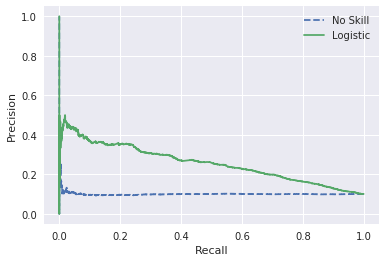

AUC(PR):0.2563217567267001


In [52]:
# precision-recall curve and f1
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc
from matplotlib import pyplot
import random
# generate a no skill prediction (majority class)
no_skill_probs = [i for i in np.random.rand(len(test_y))]
# calculate precision and recall for each threshold
ns_precision, ns_recall, _ = precision_recall_curve(test_y, no_skill_probs)
lr_precision, lr_recall, _ = precision_recall_curve(test_y, pred)

# plot the precision-recall curves
pyplot.plot(ns_recall, ns_precision, linestyle='--', label='No Skill')
pyplot.plot(lr_recall, lr_precision, linestyle='-', label='Logistic')
# axis labels
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()
from sklearn.metrics import auc
print("AUC(PR):%s" %str(auc(lr_recall, lr_precision)))

In [53]:
L.Linear.__dict__.items()

dict_items([('__module__', 'chainer.links.connection.linear'), ('_initialize_params', <function Linear._initialize_params at 0x7f89266e2ae8>), ('_abc_negative_cache_version', 205), ('__doc__', 'Linear layer (a.k.a.\\  fully-connected layer).\n\n    This is a link that wraps the :func:`~chainer.functions.linear` function,\n    and holds a weight matrix ``W`` and optionally a bias vector ``b`` as\n    parameters.\n\n    If ``initialW`` is left to the default value of ``None``, the weight matrix\n    ``W`` is initialized with i.i.d. Gaussian samples, each of which has zero\n    mean and deviation :math:`\\sqrt{1/\\text{in_size}}`. The bias vector ``b``\n    is of size ``out_size``. If the ``initial_bias`` is to left the default\n    value of ``None``, each element is initialized as zero.  If the ``nobias``\n    argument is set to ``True``, then this link does not hold a bias vector.\n\n    Args:\n        in_size (int or None): Dimension of input vectors. If unspecified or\n            ``N

In [56]:
L.Linear.__init__

<function chainer.links.connection.linear.Linear.__init__(self, in_size, out_size=None, nobias=False, initialW=None, initial_bias=None)>